# Capacited Vehicle Routing

Importing required libraries from Google OR-Tools.

In [ ]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import urllib.request
import json
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
locations=[(0,0),(200,600),(500,800),(400,-200),(-1000,-100),(-300,-300),(-50,50),(-600,200),(-600,0)]
dist_mat=[[-1]*len(locations) for i in range(len(locations))]
for i in range(0,len(locations)):
    for j in range(i,len(locations)):
        dist_mat[i][j]=dist_mat[j][i]=int(math.sqrt((locations[i][0]-locations[j][0])**2+(locations[i][1]-locations[j][1])**2))  

Get data for the problem.

In [ ]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
     # Depot(2k), Zircon, Aquamarine, Opal, OJAS, Admin,Beryl,Garnet,Orion
    data['distance_matrix'] = dist_mat
    data['demands'] = [0, 1, 1, 2, 4, 2, 1, 2, 3]
    data['vehicle_capacities'] = [5, 5, 5, 5]
    data['num_vehicles'] = 4
    data['depot'] = 0
    data['locations']=locations
    return data

In [ ]:
d=create_data_model()

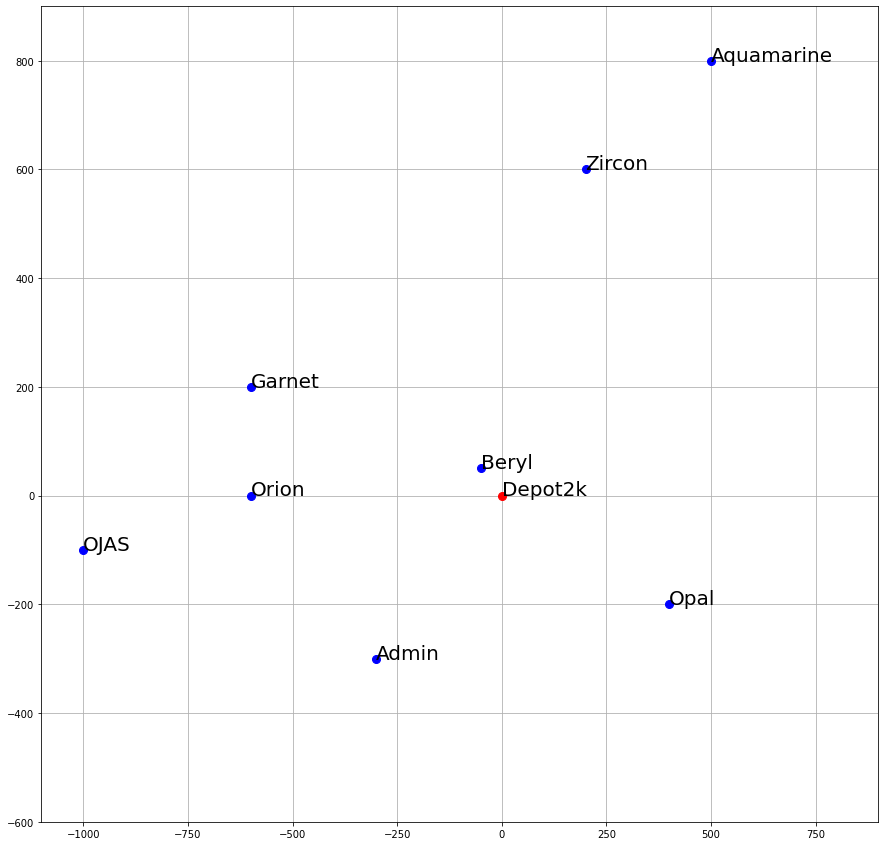

In [ ]:
fig=plt.figure(figsize=(15,15))
plt.xlim(-1100,900)
plt.ylim(-600,900)
plt.grid()
r=['Depot2k', 'Zircon', 'Aquamarine', 'Opal', 'OJAS', 'Admin','Beryl','Garnet','Orion']
for i in d['locations']:
    if i[0] == 0 and i[1] == 0:
        plt.plot(i[0], i[1], marker="o", markersize=8, markeredgecolor="red", markerfacecolor="red")
    else:
        plt.plot(i[0], i[1], marker="o", markersize=8, markeredgecolor="blue", markerfacecolor="blue")
for i in range(len(locations)):
  plt.annotate(r[i],locations[i],fontsize=20)
plt.show()

In [ ]:
locations[1][0]

200

Helper function to print the solution.

In [ ]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),
                                                 route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))

Instantiating the data problem.

In [ ]:
data = create_data_model()

Create the routing index manager.

In [ ]:
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

Create routing model.

In [ ]:
routing = pywrapcp.RoutingModel(manager)

Create and register a transit callback.

In [ ]:
def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

Define cost of each arc.

In [ ]:
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

Add Capacity constraint.

In [ ]:
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(
    demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')

True

Setting first solution heuristic.

In [ ]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
search_parameters.time_limit.FromSeconds(1)

Solve the problem.

In [ ]:
solution = routing.SolveWithParameters(search_parameters)

if solution:
    print_solution(data, manager, routing, solution)
else:
    print('No solution found !')

Objective: 6758
Route for vehicle 0:
 0 Load(0) ->  5 Load(2) ->  0 Load(2)
Distance of the route: 848m
Load of the route: 2

Route for vehicle 1:
 0 Load(0) ->  7 Load(2) ->  8 Load(5) ->  0 Load(5)
Distance of the route: 1432m
Load of the route: 5

Route for vehicle 2:
 0 Load(0) ->  1 Load(1) ->  2 Load(2) ->  3 Load(4) ->  0 Load(4)
Distance of the route: 2443m
Load of the route: 4

Route for vehicle 3:
 0 Load(0) ->  6 Load(1) ->  4 Load(5) ->  0 Load(5)
Distance of the route: 2035m
Load of the route: 5

Total distance of all routes: 6758m
Total load of all routes: 16


In [ ]:
def get_routes(solution, routing, manager):
  """Get vehicle routes from a solution and store them in an array."""
  # Get vehicle routes and store them in a two dimensional array whose
  # i,j entry is the jth location visited by vehicle i along its route.
  routes = []
  for route_nbr in range(routing.vehicles()):
    index = routing.Start(route_nbr)
    route = [manager.IndexToNode(index)]
    while not routing.IsEnd(index):
      index = solution.Value(routing.NextVar(index))
      route.append(manager.IndexToNode(index))
    routes.append(route)
  return routes
routes = get_routes(solution, routing, manager)

In [ ]:
solution

<ortools.constraint_solver.pywrapcp.Assignment; proxy of <Swig Object of type 'operations_research::Assignment *' at 0x7f4cb12e59f0> >

In [ ]:
solution.Value(routing.NextVar(2))

3

In [ ]:
routes

[[0, 5, 0], [0, 7, 8, 0], [0, 1, 2, 3, 0], [0, 6, 4, 0]]

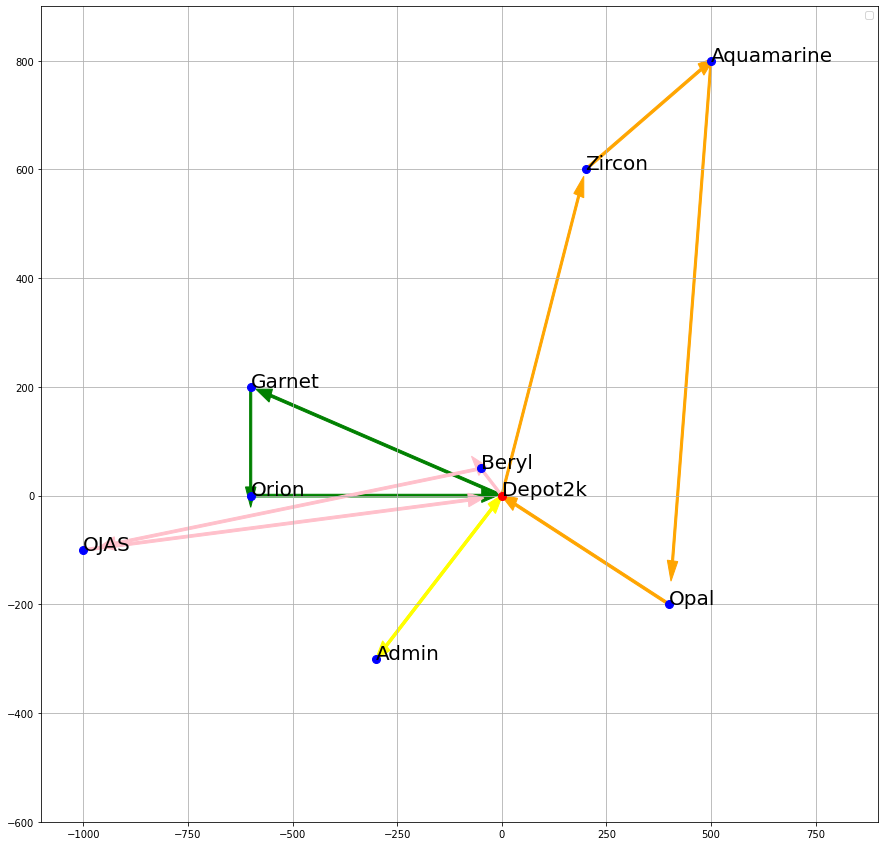

In [ ]:
fig=plt.figure(figsize=(15,15))
plt.xlim(-1100,900)
plt.ylim(-600,900)
plt.grid()
for i in d['locations']:
    if i[0] == 0 and i[1] == 0:
        plt.plot(i[0], i[1], marker="o", markersize=8, markeredgecolor="red", markerfacecolor="red")
    else:
        plt.plot(i[0], i[1], marker="o", markersize=8, markeredgecolor="blue", markerfacecolor="blue")
colors=['yellow','green','orange','pink']
for i in range(len(routes)):
  for j in range(len(routes[i])-1):

    plt.arrow(locations[routes[i][j]][0],locations[routes[i][j]][1],(locations[routes[i][j+1]][0]-locations[routes[i][j]][0])*0.92,(locations[routes[i][j+1]][1]-locations[routes[i][j]][1])*0.92,color=colors[i],linestyle='-',width=5,head_width=25,label=j)
for i in range(len(locations)):
  plt.annotate(r[i],locations[i],fontsize=20)

plt.legend()

plt.show()

In [ ]:
len(routes)

4